# Using Logistic Regression to classify the EMNIST Dataset

PyTorch provides a wide range of built-in datasets to work on like, MNIST, EMNIST, Fashion MNIST, CIFAR10 etc. In this notebook, we are using the EMNIST dataset which is split into 6 sub-datasets. We will be using the 'letters' sub-dataset, which consists of 26 balanced classes, each having 28x28 pixel images of hand-written letters from the english alphabet. The objective of the model is Hand-written Alphabet Recognition.

We'll be training the model on 124800 images from the training dataset, out of which 1% of the images will be used for the validation set, and the model will be tested on 20800 images from the test dataset.

#### Importing libraries and the EMNIST dataset 

In [1]:
import torch
import torchvision
from torchvision.datasets import EMNIST

#### Downloading the EMNIST dataset to the notebook
The root directory where we want the dataset to be downloaded, the sub-dataset and the download permissions are to be passed as arguments to get the in-built dataset to work on.

In [2]:
dataset = EMNIST(root='data/', split='letters', download=True)

Extracting data/EMNIST/raw/emnist.zip to data/EMNIST/raw
Processing byclass


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


#### Exploring the Dataset
Now, to get familiar with the dataset, we'll just look at the length of the dataset, some of the nodes of the dataset and print their image and label for some visual familiarity, and see the classes the dataset is divided into.

In [3]:
len(dataset)

124800

The training dataset contains 124800 data points.

In [4]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F67C092BEF0>, 23)

In [5]:
dataset[1]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F67C094FE10>, 7)

The first two datapoints of the training dataset are the letters 'w' (23rd alphabet) and 'g' (7th alphabet)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
classes = dataset.classes
classes

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

The 26 classes are all the letters of the english alphabet.

p


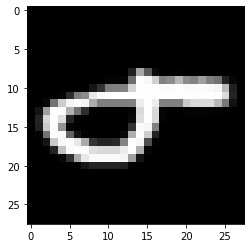

In [9]:
image, label = dataset[2]
label -= 1
plt.imshow(image, cmap='gray')
print(classes[label])

o


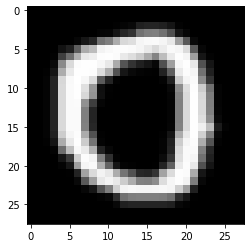

In [10]:
image, label = dataset[3]
label -= 1
plt.imshow(image, cmap='gray')
print(classes[label])

#### Transforming the images in the dataset to tensors 
To work with data points and perform operations on them, we need to convert them to tensors.

In [11]:
import torchvision.transforms as transforms

In [13]:
dataset = EMNIST(root='data/', train=True, transform=transforms.ToTensor(), split='letters')
len(dataset)

124800

#### Exploring the image tensors
Each data point has two parts: the image tensor and it's label.
The shape of the image tensor is [1, 28, 28], signifying that it only consists of one channel(lightness channel, L, since it's a grayscale image), conveyed by the first dimension; and the size of the image that 28x28 pixels, as conveyed by the subsequent 2 dimensions 

In [14]:
img_tensor, labels = dataset[0]
print(img_tensor.shape, labels-1)

torch.Size([1, 28, 28]) 22


In [15]:
img_tensor, labels = dataset[1]
print(img_tensor.shape, labels-1)

torch.Size([1, 28, 28]) 6


In [16]:
img_tensor, labels = dataset[2]
print(img_tensor, labels-1)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

#### Why do we need a validation set?
We need a validation set to check our model before finally testing it on the test dataset. It helps us to change hyperparameters accordingly to get the best results, and then pick the best version of the model before reporting the final results.

#### Create validation set from the training set
We take the 1% of the training set as our validation set in this notebook, though any small percentage can be taken. The validation set is created by randomly splitting the training dataset into two parts of suitable size. The random split plays a major role here as, if we split it in order, the training dataset might not have some classes at all, and since the model was never trained for those classes which got divided into the validation set, the model will never be able to guess them. Which means, even after training our model, our model's accuracy on the validation set will always be zero.

In [17]:
from torch.utils.data import random_split

val_per = 0.1
val_len = int(val_per*len(dataset))
train_ds, val_ds = random_split(dataset, [len(dataset)-val_len, val_len])
print(len(train_ds), len(val_ds))

112320 12480


#### Load the training and validation data in batches
We use the DataLoader to load the training and validation dataset with a batch size of 128 data points. We shuffle the training dataset because the most randomized inputs produce the most general model, which is favourable. However, we do not shuffle the validation dataset as, we cannot compare different evaluations if the dataset on which we are evaluating is not the same.

In [18]:
from torch.utils.data import DataLoader

batch_size = 128

train_load = DataLoader(train_ds, batch_size, shuffle=True)
val_load = DataLoader(val_ds, batch_size)

#### Creating a logistic regression model

Since the input and output sizes should be scalar integers for us to implement regression on them, input size can't be in the form of [28, 28], therefore, it is 28*28 = 784 (number of pixels in the image if we flatten the image). And output size is clearly 26, because the image will be classified into one of the 26 classes.

In [19]:
from torch import nn

input_size = 28*28
output_size = 26

We extend the nn.Module class to define our EmnistModel. It consists of one nn.Linear layer, invoked in the forward function after we flatten the input based on its last two dimensions(the dimensions conveying the image size), and return the output after implementing logistic regression on it.

Then we have the training step where we use the cross_entropy loss function on the predictions and targets to calculate the loss for the training dataset. In the validation step, we also calculate the accuracy of the model along with the loss on the validation set.

In the last two functions, we combine the validation losses and accuracies after each epoch, so that we can track the progress of the training.

In [20]:
class EmnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, label = batch
        labels = torch.tensor([x-1 for x in label])
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, label = batch
        labels = torch.tensor([x-1 for x in label])
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [21]:
model = EmnistModel()

#### Predictions with the initial hyperparameters

In [22]:
import torch.nn.functional as F

for images, label in train_load:
    labels = torch.tensor([x-1 for x in label])
    outputs = model(images)
    break

We pass the outputs through the softmax function so that the outputs are in the range 0 to 1 and the sum of the outputs for each data point in the batch is 1, and the outputs can represent probabilities.

In [23]:
probs = F.softmax(outputs, dim=1)

We can take the class with the highest probability as the predicted class. The 'max_probs' represents the highest probability and 'preds' represents it's index, which can be called the predicted label.

In [24]:
max_probs, preds = torch.max(probs, dim=1)
preds

tensor([ 2,  2,  2, 18,  2,  2, 15, 11,  2,  3, 18,  2, 18, 15,  2, 15,  4, 15,
         2,  9,  2, 15,  2, 13, 15,  3,  2, 15,  2, 11, 11,  2, 18, 18,  4, 18,
         3,  5, 19, 21, 15,  2, 15, 15, 15, 18,  2, 15, 18, 18,  2, 18,  2,  4,
         2,  2, 11,  2,  2,  4,  9, 11, 21,  3,  4,  2,  2,  2, 18,  3,  2,  3,
        18, 11,  2, 18, 15, 18, 13, 21,  3, 15,  2,  2, 15, 18,  2,  2,  3,  3,
         2, 23, 11, 20,  3, 11, 11, 10, 18,  3,  2,  2, 24,  2,  3,  4, 21, 15,
        19,  2,  2, 24, 11,  3, 18, 15,  2, 18, 18,  5, 18, 18,  2, 11,  2,  3,
         2,  2])

These are the labels predicted with the initial set of weights and biases. Since it's totally random, they are very likely to be wrong.

#### Defining accuracy of the model

We calculate the accuracy by checking the number of right predictions.

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
accuracy(outputs, labels)

tensor(0.0312)

The accuracy is quite low, as expected.

#### Defining the loss function

In [27]:
loss_fn = F.cross_entropy

loss = loss_fn(outputs, labels)
print(loss)

tensor(3.2834, grad_fn=<NllLossBackward>)


#### Training the model

We evaluate the model on the basis of the loss and accuracy.

We fit the model to the training and validation datasets. The optimizer we use is SGD to change the weights and biases. For each epoch, in each batch, the loss is calculated on the training data and the model parameters are updated using the optimizer, which is then initialized again, so that the gradients do not keep adding up after each epoch. We evaluate the model with the updated model parameters on the validation dataset, and add each result to history. Number of epochs and learning rate are the hyperparameters whose best value, we have to decide in order to get the best version of the model. Epochs are the iterations, and learning rate is the rate by which the model parameters are changed during gradient descent.

In [28]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [29]:
result0 = evaluate(model, val_load)
result0

{'val_acc': 0.03212691470980644, 'val_loss': 3.301173686981201}

In [30]:
history1 = fit(5, 0.001, model, train_load, val_load)

Epoch [0], val_loss: 2.9341, val_acc: 0.3096
Epoch [1], val_loss: 2.6590, val_acc: 0.4353
Epoch [2], val_loss: 2.4430, val_acc: 0.4903
Epoch [3], val_loss: 2.2728, val_acc: 0.5253
Epoch [4], val_loss: 2.1374, val_acc: 0.5447


In [31]:
history2 = fit(5, 0.01, model, train_load, val_load)

Epoch [0], val_loss: 1.5822, val_acc: 0.5969
Epoch [1], val_loss: 1.4206, val_acc: 0.6188
Epoch [2], val_loss: 1.3397, val_acc: 0.6346
Epoch [3], val_loss: 1.2890, val_acc: 0.6449
Epoch [4], val_loss: 1.2531, val_acc: 0.6519


In [32]:
history3 = fit(5, 0.02, model, train_load, val_load)

Epoch [0], val_loss: 1.2065, val_acc: 0.6618
Epoch [1], val_loss: 1.1746, val_acc: 0.6699
Epoch [2], val_loss: 1.1524, val_acc: 0.6786
Epoch [3], val_loss: 1.1355, val_acc: 0.6812
Epoch [4], val_loss: 1.1231, val_acc: 0.6854


In [33]:
history4 = fit(5, 0.01, model, train_load, val_load)

Epoch [0], val_loss: 1.1176, val_acc: 0.6871
Epoch [1], val_loss: 1.1124, val_acc: 0.6875
Epoch [2], val_loss: 1.1079, val_acc: 0.6898
Epoch [3], val_loss: 1.1037, val_acc: 0.6910
Epoch [4], val_loss: 1.0996, val_acc: 0.6917


In [34]:
history5 = fit(5, 0.001, model, train_load, val_load)

Epoch [0], val_loss: 1.0991, val_acc: 0.6926
Epoch [1], val_loss: 1.0988, val_acc: 0.6927
Epoch [2], val_loss: 1.0984, val_acc: 0.6931
Epoch [3], val_loss: 1.0981, val_acc: 0.6935
Epoch [4], val_loss: 1.0977, val_acc: 0.6935


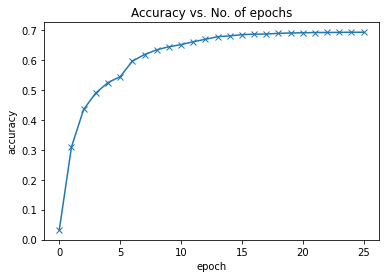

In [35]:
history = [result0] + history1 + history2 + history3 + history4 + history5
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

As we can see, the accuracy becomes constant towards the end. It means that we have reached the linear regression limit, and to get better accuracies, we will have to use to more advanced models.

#### Downloading and Transforming the test dataset
The test dataset is downloaded with train permissions as False, since we are not going to use it for training, and converted to tensors.

In [36]:
test_dataset = EMNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor(), split='letters')

In [37]:
len(test_dataset)

20800

Shape: torch.Size([1, 28, 28])
Label: 0


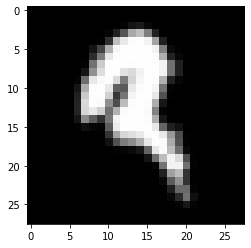

In [38]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label-1)

Shape: torch.Size([1, 28, 28])
Label: 0


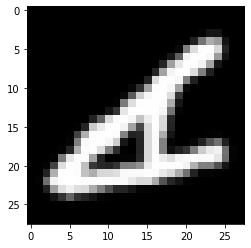

In [39]:
img, label = test_dataset[1]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label-1)

Shape: torch.Size([1, 28, 28])
Label: 3


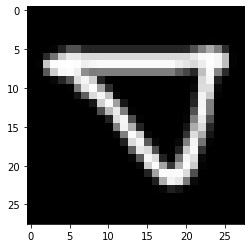

In [40]:
img, label = test_dataset[3000]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label-1)

We are adding an extra dimension, with the value 1, which the model considers as a batch with 1 image.

In [41]:
img.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

#### Test the model on the test dataset
We predict the output using the method described above, by considering the outputs as probabilities and the class with the highest probability as the prediction.

In [42]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 1 , Predicted Label: 5 , Predicted Alphabet: e


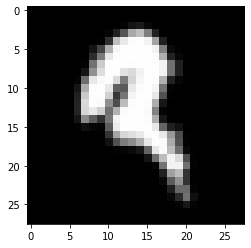

In [45]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted Label:', predict_image(img, model) + 1, ', Predicted Alphabet:', classes[predict_image(img, model)])

Label: 1 , Predicted Label: 1 , Predicted Alphabet: a


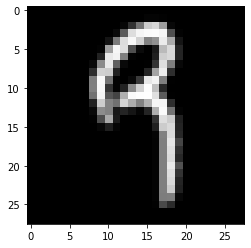

In [46]:
img, label = test_dataset[30]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted Label:', predict_image(img, model) + 1, ', Predicted Alphabet:', classes[predict_image(img, model)])

Label: 6 , Predicted Label: 6 , Predicted Alphabet: f


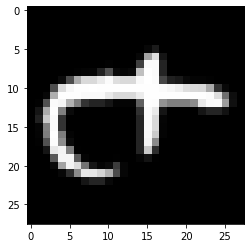

In [47]:
img, label = test_dataset[4000]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted Label:', predict_image(img, model) + 1, ', Predicted Alphabet:', classes[predict_image(img, model)])

#### Evaluate the model on the test dataset

In [48]:
test_loader = DataLoader(test_dataset, batch_size=128)
result = evaluate(model, test_loader)
result

{'val_acc': 0.6948811411857605, 'val_loss': 1.1023281812667847}

#### The final accuracy of the model on the test dataset is 69.49% using logistic regression.